# 4 Pre-Processing and Training Data<a id='4_Pre-Processing_and_Training_Data'></a>

## 4.2 Introduction<a id='4.2_Introduction'></a>

In preceding notebooks, performed preliminary assessments of data quality and refined the question to be answered. You found a column with the same value for all rows and dropped it. You determined that predicting mushroom class was your primary aim. You one hot encoded the data after using Cramer's V and Theil's U to look for any patterns between the categorical variables.

In this notebook you'll start to build machine learning models. Before even starting with learning a machine learning model, however, start by considering how useful the mode value is as a predictor. This is more than just a pedagogical device. You never want to go to stakeholders with a machine learning model only to have the CEO point out that it performs worse than just guessing the mode! Your first model is a baseline performance comparitor for any subsequent model. You then build up the process of efficiently and robustly creating and assessing models against it. The development we lay out may be little slower than in the real world, but this step of the capstone is definitely more than just instructional. It is good practice to build up an understanding that the machine learning pipelines you build work as expected. You can validate steps with your own functions for checking expected equivalence between, say, pandas and sklearn implementations.

## 4.3 Imports<a id='4.3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
# from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

from library.sb_utils import save_file

## 4.4 Load Data<a id='4.4_Load_Data'></a>

In [2]:
mushroom_data = pd.read_csv('../data/mushroom_data_step3_features.csv')
mushroom_data.T.head()

,0,1,2,3,4,5,6,7,8,9,...,8114,8115,8116,8117,8118,8119,8120,8121,8122,8123
class_p,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
cap-shape_b,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cap-shape_c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cap-shape_f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
cap-shape_k,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0


In [3]:
mushroom_data.shape

(8124, 112)

## 4.6 Train/Test Split<a id='4.6_Train/Test_Split'></a>

So far, you've treated mushroom data as a single entity. In machine learning, when you train your model on all of your data, you end up with no data set aside to evaluate model performance. You could keep making more and more complex models that fit the data better and better and not realise you were overfitting to that one set of samples. By partitioning the data into training and testing splits, without letting a model (or missing-value imputation) learn anything about the test split, you have a somewhat independent assessment of how your model might perform in the future. An often overlooked subtlety here is that people all too frequently use the test set to assess model performance _and then compare multiple models to pick the best_. This means their overall model selection process is  fitting to one specific data set, now the test split. You could keep going, trying to get better and better performance on that one data set, but that's  where cross-validation becomes especially useful. While training models, a test split is very useful as a final check on expected future performance.

What partition sizes would you have with a 70/30 train/test split?

In [4]:
len(mushroom_data) * .7, len(mushroom_data) * .3

(5686.799999999999, 2437.2)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(mushroom_data.drop(columns='class_p'), 
                                                    mushroom_data.class_p, test_size=0.3, 
                                                    random_state=47)

In [6]:
X_train.shape, X_test.shape

((5686, 111), (2438, 111))

In [7]:
y_train.shape, y_test.shape

((5686,), (2438,))

In [8]:
#Code task 2#
#Check the `dtypes` attribute of `X_train` to verify all features are numeric
X_train.dtypes.value_counts()

float64    111
dtype: int64

In [9]:
#Code task 3#
#Repeat this check for the test split in `X_test`
X_test.dtypes.value_counts()

float64    111
dtype: int64

You have only numeric features in your X now!

## 4.7 Initial Not-Even-A-Model<a id='4.7_Initial_Not-Even-A-Model'></a>

A good place to start is to see how good the mode is as a predictor. In other words, what if you simply say your best guess is the mode?

In [10]:
#Code task 4#
#Calculate the mode of `y_train`
train_mode = y_train.mode()
train_mode

0    0.0
dtype: float64

`sklearn`'s `DummyRegressor` easily does this (note that for binary variables, the median is an integer if and only if the mode is unique):

In [11]:
#Code task 5#
#Fit the dummy regressor on the training data
#Hint, call its `.fit()` method with `X_train` and `y_train` as arguments
#Then print the object's `constant_` attribute and verify it's the same as the mode above
dumb_reg = DummyRegressor(strategy='median')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[0.]])

How good is this? How closely does this match, or explain, the actual values? There are many ways of assessing how good one set of values agrees with another, which brings us to the subject of metrics.

### 4.7.1 Metrics<a id='4.7.1_Metrics'></a>

#### 4.7.1.1 Accuracy (percent correct)<a id='4.7.1.1_R-squared,_or_coefficient_of_determination'></a>

One measure is accuracy. This is a measure of the proportion of instances correctly classified by our model. 

In [12]:
from sklearn.metrics import accuracy_score

Make your predictions by creating an array of length the size of the training set with the single value of the mode.

In [13]:
y_tr_pred_ = float(train_mode) * np.ones(len(y_train))
y_tr_pred_[:5]

array([0., 0., 0., 0., 0.])

Remember the `sklearn` dummy regressor? 

In [14]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([0., 0., 0., 0., 0.])

You can see that `DummyRegressor` produces exactly the same results and saves you having to mess about broadcasting the median (or whichever other statistic we used - check out the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) to see what's available) to an array of the appropriate length. It also gives you an object with `fit()` and `predict()` methods as well so you can use them as conveniently as any other `sklearn` estimator.

In [15]:
accuracy_score(y_train, y_tr_pred)

0.5196975026380584

That was pretty abysmal, little better than a monkey flipping a coin. What if you use this "model" to predict unseen values from the test set? Remember, of course, that your "model" is trained on the training set; you still use the training set mode as your prediction.

Make your predictions by creating an array of length the size of the test set with the single value of the (training) mode.

In [16]:
y_te_pred = float(train_mode) * np.ones(len(y_test))
accuracy_score(y_test, y_te_pred)

0.5139458572600493

Generally, you can expect performance on a test set to be slightly worse than on the training set.

Accuracy is a common metric that is very straightforward, but it places equal emphasis on classifying true positives and true negatives. Metrics that focus exclusively on true (vs. false) positives or true (vs. false) negatives are precision or recall, respectively. A metric that tries to balance the two is the F1 score. Precision, recall, and F1 score are included in `scikit-learn.metric.classification_report`.

In [17]:
from sklearn.metrics import classification_report

In [18]:
print(classification_report(y_train, y_tr_pred, target_names=['edible','poisonous']))

              precision    recall  f1-score   support

      edible       0.52      1.00      0.68      2955
   poisonous       0.00      0.00      0.00      2731

    accuracy                           0.52      5686
   macro avg       0.26      0.50      0.34      5686
weighted avg       0.27      0.52      0.36      5686



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
print(classification_report(y_test, y_te_pred, target_names=['edible','poisonous']))

              precision    recall  f1-score   support

      edible       0.51      1.00      0.68      1253
   poisonous       0.00      0.00      0.00      1185

    accuracy                           0.51      2438
   macro avg       0.26      0.50      0.34      2438
weighted avg       0.26      0.51      0.35      2438



The dummy regressor always classifies everything as edible since that's the mode class. Consequently, precision and recall for the poisonous class is undefined.

### 4.7.3 Note On Calculating Metrics<a id='4.7.3_Note_On_Calculating_Metrics'></a>

When calling functions to calculate metrics, it is important to take care in the order of the arguments. One of the metrics above actually doesn't care if the arguments are reversed; the rest do. Which ones care?

In a Jupyter code cell, running `accuracy_score?` will bring up the docstring for the function, and `accuracy_score??` will bring up the actual code of the function! Try them and compare the source for `sklearn`'s function with yours. Feel free to explore what happens when you reverse the order of the arguments and compare behaviour of `sklearn`'s function and yours.

In [20]:
# train set - accuracy
# correct order, incorrect order
accuracy_score(y_train, y_tr_pred), accuracy_score(y_tr_pred, y_train)

(0.5196975026380584, 0.5196975026380584)

In [21]:
# test set - accuracy
# correct order, incorrect order
accuracy_score(y_test, y_te_pred), accuracy_score(y_te_pred, y_test)

(0.5139458572600493, 0.5139458572600493)

In [22]:
# train set - precision, recall, F1 score
print(classification_report(y_train, y_tr_pred, target_names=['edible','poisonous'])) 
print(classification_report(y_tr_pred, y_train, target_names=['edible','poisonous']))

              precision    recall  f1-score   support

      edible       0.52      1.00      0.68      2955
   poisonous       0.00      0.00      0.00      2731

    accuracy                           0.52      5686
   macro avg       0.26      0.50      0.34      5686
weighted avg       0.27      0.52      0.36      5686

              precision    recall  f1-score   support

      edible       1.00      0.52      0.68      5686
   poisonous       0.00      0.00      0.00         0

    accuracy                           0.52      5686
   macro avg       0.50      0.26      0.34      5686
weighted avg       1.00      0.52      0.68      5686



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# test set - precision, recall, F1 score
# correct order, incorrect order
print(classification_report(y_test, y_te_pred, target_names=['edible','poisonous'])) 
print(classification_report(y_te_pred, y_test, target_names=['edible','poisonous']))

              precision    recall  f1-score   support

      edible       0.51      1.00      0.68      1253
   poisonous       0.00      0.00      0.00      1185

    accuracy                           0.51      2438
   macro avg       0.26      0.50      0.34      2438
weighted avg       0.26      0.51      0.35      2438

              precision    recall  f1-score   support

      edible       1.00      0.51      0.68      2438
   poisonous       0.00      0.00      0.00         0

    accuracy                           0.51      2438
   macro avg       0.50      0.26      0.34      2438
weighted avg       1.00      0.51      0.68      2438



You can get very different results swapping the argument order. It's worth highlighting this because data scientists do this too much in the real world! Don't be one of them! Frequently the argument order doesn't matter, but it will bite you when you do it with a function that does care. It's sloppy, bad practice and if you don't make a habit of putting arguments in the right order, you will forget!

Remember:
* argument order matters,
* check function syntax with `func?` in a code cell

## 4.8 Initial Models<a id='4.8_Initial_Models'></a>

##### 4.8.1.1.3 Scale the data<a id='4.8.1.1.3_Scale_the_data'></a>

As you have features measured in many different units, with numbers that vary by orders of magnitude, start off by scaling them to put them all on a consistent scale. The [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) scales each feature to zero mean and unit variance.

In [24]:
#Code task 10#
#Call the StandardScaler`s fit method on `X_tr` to fit the scaler
#then use it's `transform()` method to apply the scaling to both the train and test split
#data (`X_tr` and `X_te`), naming the results `X_tr_scaled` and `X_te_scaled`, respectively
scaler = StandardScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

##### 4.8.1.1.4 Train the model on the train split<a id='4.8.1.1.4_Train_the_model_on_the_train_split'></a>

In [25]:
lm = LogisticRegression().fit(X_tr_scaled, y_train)

##### 4.8.1.1.5 Make predictions using the model on both train and test splits<a id='4.8.1.1.5_Make_predictions_using_the_model_on_both_train_and_test_splits'></a>

In [26]:
#Code task 11#
#Call the `predict()` method of the model (`lm`) on both the (scaled) train and test data
#Assign the predictions to `y_tr_pred` and `y_te_pred`, respectively
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

##### 4.8.1.1.6 Assess model performance<a id='4.8.1.1.6_Assess_model_performance'></a>

In [27]:
# accuracy - train, test
scaled_accuracy = accuracy_score(y_train, y_tr_pred), accuracy_score(y_test, y_te_pred)
scaled_accuracy

(1.0, 1.0)

Recall that you estimated mushroom class by simply using the mode, a known average. As expected, this produced an accuracy score of slightly better than 1/2 for both the training and test set, because accuracy tells us how much of the predictions you were getting correct, and you were using just the mode. Here we see that our simple logistic regression model is 100% accurate. Clearly you are onto something. Note that you've made no effort to select a parsimonious set of features or deal with multicollinearity in our data.

In [28]:
#Code task 12#
#Now calculate the mean absolute error scores using `sklearn`'s `mean_absolute_error` function
# as we did above for R^2
# MAE - train, test
scaled_classification_report = classification_report(y_train, y_tr_pred, target_names=['edible','poisonous'])+'\n'+classification_report(y_test, y_te_pred, target_names=['edible','poisonous'])
print(scaled_classification_report)

              precision    recall  f1-score   support

      edible       1.00      1.00      1.00      2955
   poisonous       1.00      1.00      1.00      2731

    accuracy                           1.00      5686
   macro avg       1.00      1.00      1.00      5686
weighted avg       1.00      1.00      1.00      5686

              precision    recall  f1-score   support

      edible       1.00      1.00      1.00      1253
   poisonous       1.00      1.00      1.00      1185

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



Using this model, then, on average you'd expect to estimate mushroom class very accurately. This is much, much better than guessing using the average. There may be something to this machine learning lark after all!

### 4.8.2 Pipelines<a id='4.8.2_Pipelines'></a>

One of the most important and useful components of `sklearn` is the [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Remember the first logistic regression model above performed the steps:

1. scale the data to zero mean and unit variance
2. train a logistic regression model

and all these steps were trained on the train split and then applied to the test split for assessment.

The pipeline below defines exactly those same steps. Crucially, the resultant `Pipeline` object has a `fit()` method and a `predict()` method, just like the `LogisticRegression()` object itself. Just as you might create a logistic regression model and train it with `.fit()` and predict with `.predict()`, you can wrap the entire process of feature scaling and regression in a single object you can train with `.fit()` and predict with `.predict()`. And that's basically a pipeline: a model on steroids.

#### 4.8.2.1 Define the pipeline<a id='4.8.2.1_Define_the_pipeline'></a>

In [29]:
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=47)
)

In [30]:
type(pipe)

sklearn.pipeline.Pipeline

In [31]:
hasattr(pipe, 'fit'), hasattr(pipe, 'predict')

(True, True)

#### 4.8.2.2 Fit the pipeline<a id='4.8.2.2_Fit_the_pipeline'></a>

Here, a single call to the pipeline's `fit()` method combines the steps of learning the imputation (determining what values to use to fill the missing ones), the scaling (determining the mean to subtract and the variance to divide by), and then training the model. It does this all in the one call with the training data as arguments.

In [32]:
#Code task 15#
#Call the pipe's `fit()` method with `X_train` and `y_train` as arguments
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=47))])

#### 4.8.2.3 Make predictions on the train and test sets<a id='4.8.2.3_Make_predictions_on_the_train_and_test_sets'></a>

In [33]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

#### 4.8.2.4 Assess performance<a id='4.8.2.4_Assess_performance'></a>

In [34]:
accuracy_score(y_train, y_tr_pred), accuracy_score(y_test, y_te_pred)

(1.0, 1.0)

And compare with your earlier (non-pipeline) result:

In [35]:
scaled_accuracy

(1.0, 1.0)

In [36]:
print(classification_report(y_train, y_tr_pred, target_names=['edible','poisonous']))
print(classification_report(y_test, y_te_pred, target_names=['edible','poisonous']))

              precision    recall  f1-score   support

      edible       1.00      1.00      1.00      2955
   poisonous       1.00      1.00      1.00      2731

    accuracy                           1.00      5686
   macro avg       1.00      1.00      1.00      5686
weighted avg       1.00      1.00      1.00      5686

              precision    recall  f1-score   support

      edible       1.00      1.00      1.00      1253
   poisonous       1.00      1.00      1.00      1185

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



Compare with your earlier result:

In [37]:
print(scaled_classification_report)

              precision    recall  f1-score   support

      edible       1.00      1.00      1.00      2955
   poisonous       1.00      1.00      1.00      2731

    accuracy                           1.00      5686
   macro avg       1.00      1.00      1.00      5686
weighted avg       1.00      1.00      1.00      5686

              precision    recall  f1-score   support

      edible       1.00      1.00      1.00      1253
   poisonous       1.00      1.00      1.00      1185

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



These results confirm the pipeline is doing exactly what's expected, and results are identical to your earlier steps. This allows you to move faster but with confidence.

## 4.9 Refining The Logistic Regression Model<a id='4.9_Refining_The_Logistic_Regression_Model'></a>

You suspected the model was overfitting. This is no real surprise given the number of features you blindly used. It's likely a judicious subset of features would generalize better. `sklearn` has a number of feature selection functions available. The one you'll use here is `SelectKBest` which, as you might guess, selects the k best features. You can read about SelectKBest 
[here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest). `f_regression` is just the [score function](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression) you're using because you're performing regression. It's important to choose an appropriate one for your machine learning task.

### 4.9.1 Define the pipeline<a id='4.9.1_Define_the_pipeline'></a>

Redefine your pipeline to include this feature selection step:

In [38]:
#Code task 16#
#Add `SelectKBest` as a step in the pipeline between `StandardScaler()` and `LogisticRegression()`
#Don't forget to tell it to use `f_regression` as its score function
pipe = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression),
    LogisticRegression(random_state=47)
)

### 4.9.2 Fit the pipeline<a id='4.9.2_Fit_the_pipeline'></a>

In [39]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x12cf75af0>)),
                ('logisticregression', LogisticRegression(random_state=47))])

### 4.9.3 Assess performance on the train and test set<a id='4.9.3_Assess_performance_on_the_train_and_test_set'></a>

In [40]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [41]:
accuracy_score(y_train, y_tr_pred), accuracy_score(y_test, y_te_pred)

(0.9780161800914526, 0.9757998359310911)

In [42]:
print(classification_report(y_train, y_tr_pred, target_names=['edible','poisonous']))
print(classification_report(y_test, y_te_pred, target_names=['edible','poisonous']))

              precision    recall  f1-score   support

      edible       0.98      0.98      0.98      2955
   poisonous       0.98      0.98      0.98      2731

    accuracy                           0.98      5686
   macro avg       0.98      0.98      0.98      5686
weighted avg       0.98      0.98      0.98      5686

              precision    recall  f1-score   support

      edible       0.98      0.98      0.98      1253
   poisonous       0.97      0.98      0.98      1185

    accuracy                           0.98      2438
   macro avg       0.98      0.98      0.98      2438
weighted avg       0.98      0.98      0.98      2438



This has made things worse! Clearly selecting a subset of features has an impact on performance. `SelectKBest` defaults to k=10. You've just seen that 10 is worse than using all features. What is the best k? You could create a new pipeline with a different value of k:

### 4.9.4 Define a new pipeline to select a different number of features<a id='4.9.4_Define_a_new_pipeline_to_select_a_different_number_of_features'></a>

In [43]:
#Code task 17#
#Modify the `SelectKBest` step to use a value of 15 for k
pipe15 = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression, k=15),
    LogisticRegression(random_state=47)
)

### 4.9.5 Fit the pipeline<a id='4.9.5_Fit_the_pipeline'></a>

In [44]:
pipe15.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=15,
                             score_func=<function f_regression at 0x12cf75af0>)),
                ('logisticregression', LogisticRegression(random_state=47))])

### 4.9.6 Assess performance on train and test data<a id='4.9.6_Assess_performance_on_train_and_test_data'></a>

In [45]:
y_tr_pred = pipe15.predict(X_train)
y_te_pred = pipe15.predict(X_test)

In [46]:
accuracy_score(y_train, y_tr_pred), accuracy_score(y_test, y_te_pred)

(0.979071403447063, 0.9766201804757998)

In [47]:
print(classification_report(y_train, y_tr_pred, target_names=['edible','poisonous']))
print(classification_report(y_test, y_te_pred, target_names=['edible','poisonous']))

              precision    recall  f1-score   support

      edible       0.98      0.98      0.98      2955
   poisonous       0.98      0.98      0.98      2731

    accuracy                           0.98      5686
   macro avg       0.98      0.98      0.98      5686
weighted avg       0.98      0.98      0.98      5686

              precision    recall  f1-score   support

      edible       0.98      0.98      0.98      1253
   poisonous       0.97      0.98      0.98      1185

    accuracy                           0.98      2438
   macro avg       0.98      0.98      0.98      2438
weighted avg       0.98      0.98      0.98      2438



You could keep going, trying different values of k, training a model, measuring performance on the test set, and then picking the model with the best test set performance. There's a fundamental problem with this approach: _you're tuning the model to the arbitrary test set_! If you continue this way you'll end up with a model works well on the particular quirks of our test set _but fails to generalize to new data_. The whole point of keeping a test set is for it to be a set of that new data, to check how well our model might perform on data it hasn't seen.

The way around this is a technique called _cross-validation_. You partition the training set into k folds, train our model on k-1 of those folds, and calculate performance on the fold not used in training. This procedure then cycles through k times with a different fold held back each time. Thus you end up building k models on k sets of data with k estimates of how the model performs on unseen data but without having to touch the test set.

### 4.9.7 Assessing performance using cross-validation<a id='4.9.7_Assessing_performance_using_cross-validation'></a>

In [48]:
cv_results = cross_validate(pipe15, X_train, y_train, cv=5)

In [49]:
cv_scores = cv_results['test_score']
cv_scores

array([0.9771529 , 0.9762533 , 0.98240985, 0.97801231, 0.97185576])

Without using the same random state for initializing the CV folds, your actual numbers will be different.

In [50]:
np.mean(cv_scores), np.std(cv_scores)

(0.9771368244679289, 0.0033835423633296505)

These results highlight that assessing model performance in inherently open to variability. You'll get different results depending on the quirks of which points are in which fold. An advantage of this is that you can also obtain an estimate of the variability, or uncertainty, in your performance estimate.

In [51]:
np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)

array([0.97, 0.98])

### 4.9.8 Hyperparameter search using GridSearchCV<a id='4.9.8_Hyperparameter_search_using_GridSearchCV'></a>

Pulling the above together, we have:
* a pipeline that
    * scales the data
    * selects the k best features
    * trains a logistic regression model
* a technique (cross-validation) for estimating model performance

Now you want to use cross-validation for multiple values of k and use cross-validation to pick the value of k that gives the best performance. `make_pipeline` automatically names each step as the lowercase name of the step and the parameters of the step are then accessed by appending a double underscore followed by the parameter name. You know the name of the step will be 'selectkbest' and you know the parameter is 'k'.

You can also list the names of all the parameters in a pipeline like this:

In [52]:
#Code task 18#
#Call `pipe`'s `get_params()` method to get a dict of available parameters and print their names
#using dict's `keys()` method
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'selectkbest', 'logisticregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])

The above can be particularly useful as your pipelines becomes more complex (you can even nest pipelines within pipelines).

In [53]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

Now you have a range of `k` to investigate. Is 1 feature best? 2? 3? 4? All of them? You could write a for loop and iterate over each possible value, doing all the housekeeping oyurselves to track the best value of k. But this is  a common task so there's a built in function in `sklearn`. This is [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
This takes the pipeline object, in fact it takes anything with a `.fit()` and `.predict()` method. In simple cases with no feature selection or imputation or feature scaling etc. you may see the classifier or regressor object itself directly passed into `GridSearchCV`. The other key input is the parameters and values to search over. Optional parameters include the cross-validation strategy and number of CPUs to use.

In [54]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [55]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x12cf75af0>)),
                                       ('logisticregression',
                                        LogisticRegression(random_state=47))]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [56]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [57]:
#Code task 19#
#Print the `best_params_` attribute of `lr_grid_cv`
lr_grid_cv.best_params_

{'selectkbest__k': 36}

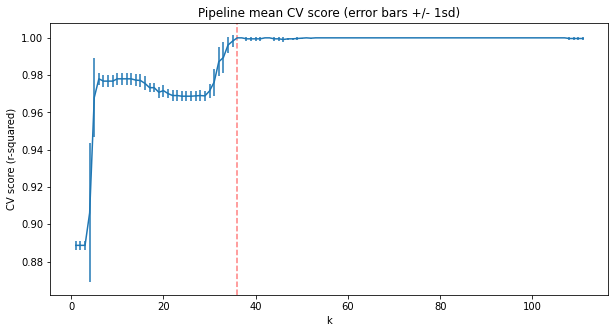

In [58]:
#Code task 20#
#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

The above suggests a good value for k is 36. There was an initial rapid increase with k, followed by a slow decline, followed by another rapid increase with k, followed by a slow decline. Also noticeable is the variance of the results greatly increase above k=36. As you increasingly overfit, expect greater swings in performance as different points move in and out of the train/test folds.

Which features were most useful? Step into your best model, shown below. Starting with the fitted grid search object, you get the best estimator, then the named step 'selectkbest', for which you can its `get_support()` method for a logical mask of the features selected.

In [59]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

Similarly, instead of using the 'selectkbest' named step, you can access the named step for the logistic regression model and, from that, grab the model coefficients via its `coef_` attribute:

In [60]:
#Code task 21#
#Get the logistic regression model coefficients from the `coef_` attribute and store in `coefs`,
#get the matching feature names from the column names of the dataframe,
#and display the results as a pandas Series with `coefs` as the values and `features` as the index,
#sorting the values in descending order
coefs = lr_grid_cv.best_estimator_.named_steps.logisticregression.coef_
features = X_train.columns[selected]
pd.Series(coefs[0], index=features).sort_values(ascending=False)

stalk-surface-above-ring_k    2.399097
gill-size_n                   2.145498
bruises_t                     1.740952
stalk-root_c                  1.244297
gill-color_b                  1.167545
ring-type_p                   0.862045
odor_f                        0.816103
odor_s                        0.565131
odor_y                        0.545991
ring-type_l                   0.433094
population_v                  0.371077
stalk-color-above-ring_b      0.090369
stalk-color-below-ring_b      0.086778
ring-type_e                   0.052600
population_a                 -0.009958
gill-color_w                 -0.049258
stalk-color-above-ring_n     -0.069528
stalk-surface-above-ring_s   -0.160142
gill-color_n                 -0.236546
stalk-surface-below-ring_k   -0.269999
stalk-surface-below-ring_s   -0.282371
population_n                 -0.483190
stalk-color-below-ring_p     -0.497216
stalk-color-above-ring_p     -0.519197
stalk-color-above-ring_g     -0.661698
stalk-color-below-ring_g 

These results suggest that silky stalk surfaces above the ring are the most poisonous feature. This makes intuitive sense and is consistent with what you saw during the EDA work. Also, you see that narrow gills are very poisonous. The coefficient for anise, almond, and no odors is strongly negative _for this model_. If a mushroom smells like anise or almond or doesn't have a scent, it is much less likely to be poisonous. It is also less likely to be poisonous if the spore prints are black or brown.

## 4.10 Random Forest Model<a id='4.10_Random_Forest_Model'></a>

A model that can work very well in a lot of cases is the random forest. For regression, this is provided by `sklearn`'s `RandomForestRegressor` class.

Time to stop the bad practice of repeatedly checking performance on the test split. Instead, go straight from defining the pipeline to assessing performance using cross-validation. `cross_validate` will perform the fitting as part of the process. This uses the default settings for the random forest so you'll then proceed to investigate some different hyperparameters.

### 4.10.1 Define the pipeline<a id='4.10.1_Define_the_pipeline'></a>

In [61]:
#Code task 22#
#Define a pipeline comprising the steps:
#StandardScaler(),
#and RandomForestRegressor() with a random state of 47
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(random_state=47)
)

### 4.10.2 Fit and assess performance using cross-validation<a id='4.10.2_Fit_and_assess_performance_using_cross-validation'></a>

In [62]:
#Code task 23#
#Call `cross_validate` to estimate the pipeline's performance.
#Pass it the random forest pipe object, `X_train` and `y_train`,
#and get it to use 5-fold cross-validation
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [63]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([1., 1., 1., 1., 1.])

In [64]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(1.0, 0.0)

### 4.10.3 Hyperparameter search using GridSearchCV<a id='4.10.3_Hyperparameter_search_using_GridSearchCV'></a>

Random forest has a number of hyperparameters that can be explored, however here you'll limit yourselves to exploring some different values for the number of trees. You'll try it with and without feature scaling, and try both the mean and median as strategies for imputing missing values.

In [65]:
n_est = [int(n) for n in range(1,21)]
grid_params = {
        'randomforestclassifier__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None]
}
grid_params

{'randomforestclassifier__n_estimators': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20],
 'standardscaler': [StandardScaler(), None]}

In [66]:
#Code task 24#
#Call `GridSearchCV` with the random forest pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation, and all available CPU cores (if desired)
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [67]:
#Code task 25#
#Now call the `GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. This may take a minute or two.
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__n_estimators': [1, 2, 3, 4, 5,
                                                                  6, 7, 8, 9,
                                                                  10, 11, 12,
                                                                  13, 14, 15,
                                                                  16, 17, 18,
                                                                  19, 20],
                         'standardscaler': [StandardScaler(), None]})

In [68]:
#Code task 26#
#Print the best params (`best_params_` attribute) from the grid search
rf_grid_cv.best_params_

{'randomforestclassifier__n_estimators': 3, 'standardscaler': StandardScaler()}

It looks like scaling the features helps.

In [69]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([1., 1., 1., 1., 1.])

In [70]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(1.0, 0.0)

You've marginally improved upon the default CV results. Random forest has many more hyperparameters you could tune, but we won't dive into that here.

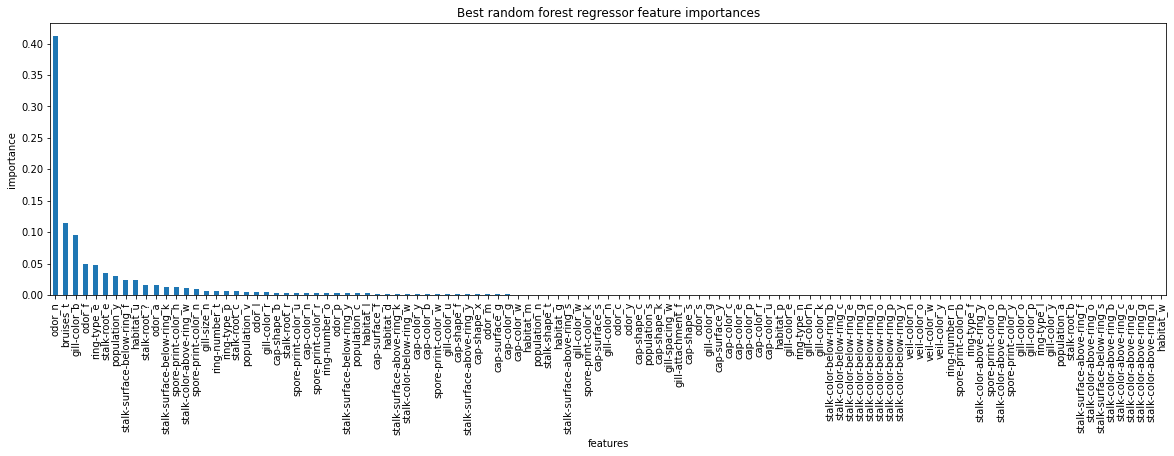

In [71]:
#Code task 27#
#Plot a barplot of the random forest's feature importances,
#assigning the `feature_importances_` attribute of 
#`rf_grid_cv.best_estimator_.named_steps.randomforestregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(20, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestclassifier.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

The dominant top four features are also important in your logistic regression model:
* no odor
* bruises
* buff gill color
* foul odor

## 4.11 Final Model Selection<a id='4.11_Final_Model_Selection'></a>

Time to select your final model to use for further business modeling! It would be good to revisit the above model selection; there is undoubtedly more that could be done to explore possible hyperparameters.
It would also be worthwhile to investigate removing the least useful features. Gathering or calculating, and storing, features adds business cost and dependencies, so if features genuinely are not needed they should be removed.
Building a simpler model with fewer features can also have the advantage of being easier to sell (and/or explain) to stakeholders.
Certainly there seem to be two strong features here and so a model using only those would probably work well.
However, you want to explore some different scenarios where other features vary so keep the fuller 
model for now. 
The business is waiting for this model and you have something that you have confidence in to be much better than guessing with the average poisonousness.

Or, rather, you have two "somethings". You built a best logistic regression model and a best random forest model. You need to finally choose between them. You can calculate the mean absolute error using cross-validation. Although `cross-validate` defaults to the accuracy [metric for scoring](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring) logistic regression, you can specify the recall as an alternative via
the `scoring` parameter.

### 4.11.1 Logistic regression model performance<a id='4.11.1_Logistic_regression_model_performance'></a>

In [72]:
# 'recall' uses the recall
lr_recall = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='recall', cv=5, n_jobs=-1)

In [73]:
lr_recall_mean = np.mean(lr_recall['test_score'])
lr_recall_std = np.std(lr_recall['test_score'])
lr_recall_mean, lr_recall_std

(1.0, 0.0)

In [74]:
print(classification_report(y_test, lr_grid_cv.best_estimator_.predict(X_test), target_names=['edible','poisonous']))

              precision    recall  f1-score   support

      edible       1.00      1.00      1.00      1253
   poisonous       1.00      1.00      1.00      1185

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



### 4.11.2 Random forest regression model performance<a id='4.11.2_Random_forest_regression_model_performance'></a>

In [75]:
rf_recall = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='recall', cv=5, n_jobs=-1)

In [76]:
rf_recall_mean = np.mean(rf_recall['test_score'])
rf_recall_std = np.std(rf_recall['test_score'])
rf_recall_mean, rf_recall_std

(1.0, 0.0)

In [77]:
print(classification_report(y_test, rf_grid_cv.best_estimator_.predict(X_test), target_names=['edible','poisonous']))

              precision    recall  f1-score   support

      edible       1.00      1.00      1.00      1253
   poisonous       1.00      1.00      1.00      1185

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



### 4.11.3 Conclusion<a id='4.11.3_Conclusion'></a>

Both models have roughly the same cross-validation mean absolute error. They also exhibit little variability. Verifying performance on the test set produces performance consistent with the cross-validation results.

## 4.12 Data quantity assessment<a id='4.12_Data_quantity_assessment'></a>

Finally, you need to advise the business whether it needs to undertake further data collection. Would more data be useful? We're often led to believe more data is always good, but gathering data invariably has a cost associated with it. Assess this trade off by seeing how performance varies with differing data set sizes. The `learning_curve` function does this conveniently.

In [78]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(lr_grid_cv.best_estimator_, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divid

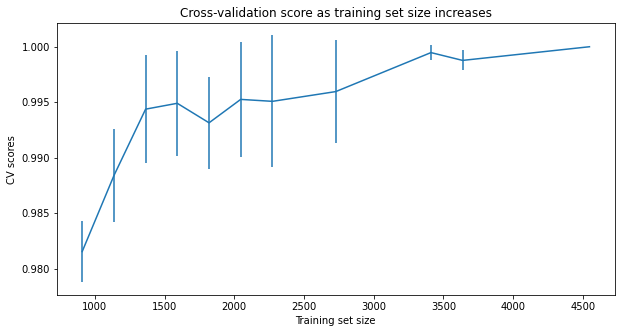

In [79]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

In [80]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(rf_grid_cv.best_estimator_, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

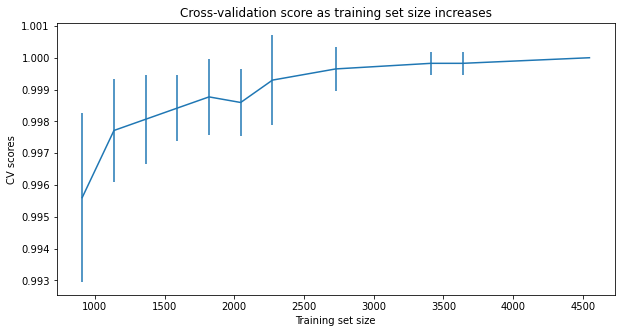

In [81]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

This shows that you seem to have plenty of data. There's an initial rapid improvement in model scores as one would expect, but it eventually levels off by around a sample size of 3500.

## 4.13 Save best model object from pipeline<a id='4.13_Save_best_model_object_from_pipeline'></a>

In [82]:
#Code task 28#
#This may not be "production grade ML deployment" practice, but adding some basic
#information to your saved models can save your bacon in development.
#Just what version model have you just loaded to reuse? What version of `sklearn`
#created it? When did you make it?
#Assign the pandas version number (`pd.__version__`) to the `pandas_version` attribute,
#the numpy version (`np.__version__`) to the `numpy_version` attribute,
#the sklearn version (`sklearn_version`) to the `sklearn_version` attribute,
#and the current datetime (`datetime.datetime.now()`) to the `build_datetime` attribute
#Let's call this model version '1.0'
best_model = lr_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [83]:
# save the model

modelpath = '../models'
save_file(best_model, 'mushroom_class_model.pkl', modelpath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../models/mushroom_class_model.pkl"


## 4.14 Summary<a id='4.14_Summary'></a>

**Q: 1** Write a summary of the work in this notebook. Capture the fact that you gained a baseline idea of performance by simply taking the average price and how well that did. Then highlight that you built a logistic regression model and the features that found. Comment on the estimate of its performance from cross-validation and whether its performance on the test split was consistent with this estimate. Also highlight that a random forest regressor was tried, what preprocessing steps were found to be best, and again what its estimated performance via cross-validation was and whether its performance on the test set was consistent with that. State which model you have decided to use going forwards and why. This summary should provide a quick overview for someone wanting to know quickly why the given model was chosen for the next part of the business problem to help guide important business decisions.

**A: 1** First, we checked what would happen if we just took the mode, and the performance on the test set was as expected, with an abysmal accuracy score. There was a training accuracy of 52% and a testing accuracy of 51%.

Then we built a logistic regression model by scaling the data and applying logistic regression. Our initial results on the test set were very good. We refined our model, modifying our pipeline to select the k best features, cross validate, and optimize with respect to k. We found that it was optimal to use the k=32 best features. The features included silky stalk surfaces above the ring and narrow gills, which were the most poisonous, and anise, almond, and no odors and black or brown spore prints, which were the least poisonous. The recall from cross validation was 100%, and the recall on the test split was 100%. The performance on the test split was consistent with the performance from cross-validation.

Next, we tried a random forest regression model, with an initial pipeline consisting of scaling the data and applying random forest regression. We did a hyperparameter search, with various numbers of trees and the option of scaling or not scaling the data. We found that it was optimal to use 3 trees and scale the data. The four most important features were no odor, bruises, buff gills, and foul odor. The recall from cross validation was 100%, and the recall on the test split was also 100%. The performance on the test split was consistent with the performance from cross-validation.

Going forwards, we have decided to use the logistic regression model because it is simpler, and the model coefficients can easily be exported.